## 1. Which college majors will pay the bills?
<p align="center"><img src="https://assets.datacamp.com/production/project_584/img/salary.png" width="400" align="center"></p>
<p>Wondering if that Philosophy major will really help you pay the bills? Think you're set with an Engineering degree? Choosing a college major is a complex decision evaluating personal interest, difficulty, and career prospects. Your first paycheck right out of college might say a lot about your salary potential by mid-career. Whether you're in school or navigating the postgrad world, join me as we explore the short and long term financial implications of this <em>major</em> decision.</p>
<p>In this notebook, I'll be using data collected from a year-long survey of 1.2 million people with only a bachelor's degree by PayScale Inc., made available <a href="http://online.wsj.com/public/resources/documents/info-Degrees_that_Pay_you_Back-sort.html?mod=article_inline">here</a> by the Wall Street Journal for their article <a href="https://www.wsj.com/articles/SB121746658635199271">Ivy League's Big Edge: Starting Pay</a>. After doing some data clean up, we'll compare the recommendations from three different methods for determining the optimal number of clusters, apply a k-means clustering analysis, and visualize the results.</p>

In [2]:
# Load relevant packages
# .... YOUR CODE FOR TASK 1 ....
library(tidyr)
library(dplyr)
library(readr)
library(ggplot2)
library(cluster)
library(factoextra)
# Read in the dataset
degrees <- read_csv("degrees-that-pay-back.csv", 
                    col_names=c("College.Major",
                                "Starting.Median.Salary",
                                "Mid.Career.Median.Salary",
                                "Career.Percent.Growth",
                                "Percentile.10",
                                "Percentile.25",
                                "Percentile.75",
                                "Percentile.90"),
                    skip=0)

# Display the first few rows and a summary of the data frame
# .... YOUR CODE FOR TASK 1 ....
# head(degrees)
summary(degrees)

Warning message:
"replacing previous import 'vctrs::data_frame' by 'tibble::data_frame' when loading 'dplyr'"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Welcome! Related Books: `Practical Guide To Cluster Analysis in R` at https://goo.gl/13EFCZ
Parsed with column specification:
cols(
  College.Major = col_character(),
  Starting.Median.Salary = col_character(),
  Mid.Career.Median.Salary = col_character(),
  Career.Percent.Growth = col_character(),
  Percentile.10 = col_character(),
  Percentile.25 = col_character(),
  Percentile.75 = col_character(),
  Percentile.90 = col_character()
)


 College.Major      Starting.Median.Salary Mid.Career.Median.Salary
 Length:51          Length:51              Length:51               
 Class :character   Class :character       Class :character        
 Mode  :character   Mode  :character       Mode  :character        
 Career.Percent.Growth Percentile.10      Percentile.25      Percentile.75     
 Length:51             Length:51          Length:51          Length:51         
 Class :character      Class :character   Class :character   Class :character  
 Mode  :character      Mode  :character   Mode  :character   Mode  :character  
 Percentile.90     
 Length:51         
 Class :character  
 Mode  :character  

## 2. Data cleaning
<p> When we initially load our data, R does not differentiate between strings and currencies, so I will clean the data by removing those special characters to convert those columns to numerics.

In [4]:
# Clean up the data
degrees_clean <- degrees %>% 
    mutate_at(vars(setdiff(names(degrees),c('College.Major'))), 
              function(x) as.numeric(gsub('\\$','',gsub('\\,','',x)))) %>% 
    mutate_at(vars(c('Career.Percent.Growth')), 
              function(x) x/100) 
degrees_clean<-na.omit(degrees_clean)
    # .... YOUR CODE FOR TASK 2 ....
# degrees_clean(c('Career.Percent.Growth'))<-as.numeric(degrees_clean(c('College.Major')))
names(degrees_clean)                

Warning message in (function (x) :
"NAs introduced by coercion"Warning message in (function (x) :
"NAs introduced by coercion"Warning message in (function (x) :
"NAs introduced by coercion"Warning message in (function (x) :
"NAs introduced by coercion"Warning message in (function (x) :
"NAs introduced by coercion"Warning message in (function (x) :
"NAs introduced by coercion"Warning message in (function (x) :
"NAs introduced by coercion"

[1] "College.Major"            "Starting.Median.Salary"  
[3] "Mid.Career.Median.Salary" "Career.Percent.Growth"   
[5] "Percentile.10"            "Percentile.25"           
[7] "Percentile.75"            "Percentile.90"

## 3. Finding the optimum vaue of K
<p>I will be visualizing 3 different methods to find the optimum value of k: </p>
<ul>
<li>Elbow Method</li>
<li>Silhouette Method</li>
<li>Gap Statistic Method</li>
</ul>

#### 3a. The elbow method
<p>First up will be the <strong>Elbow Method</strong>. This method plots the percent variance against the number of clusters. The "elbow" bend of the curve indicates the optimal point at which adding more clusters will no longer explain a significant amount of the variance. 

As seen below, the optimum value of num_clusters here would be 3. </p>

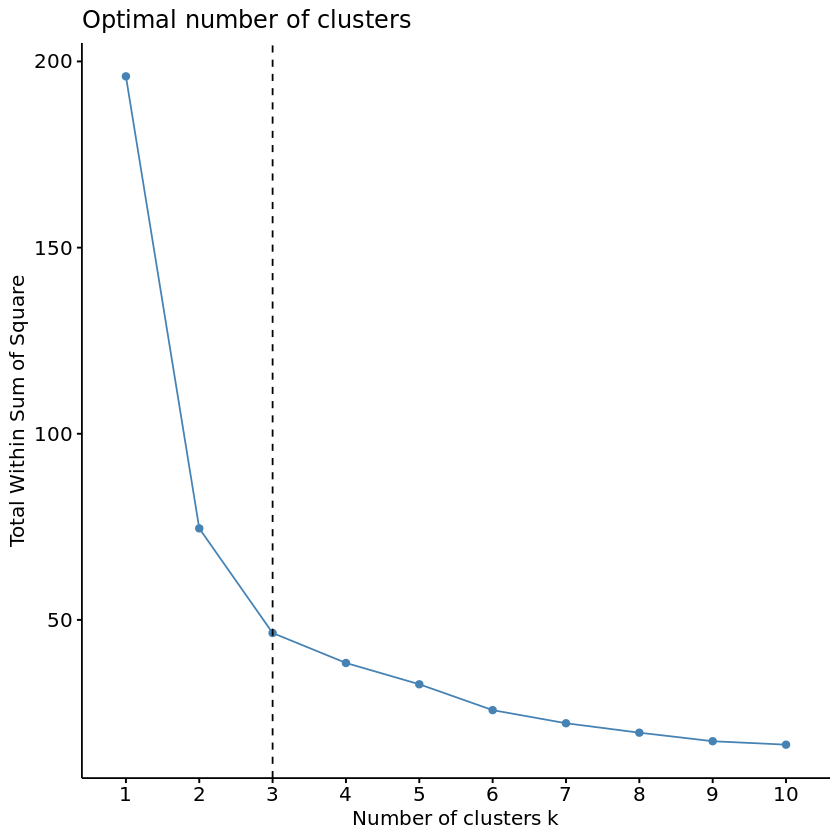

In [6]:
# Select and scale the relevant features and store as k_means_data
k_means_data <- degrees_clean %>%
    select(Starting.Median.Salary, Mid.Career.Median.Salary, Percentile.10, Percentile.90)
    # .... YOUR CODE FOR TASK 3 .... 
k_means_data <- scale(k_means_data[,])
# # Run the fviz_nbclust function with our selected data and method "wss"
elbow_method <- fviz_nbclust(k_means_data, kmeans, method ="wss")

# # View the plot
elbow_method +
geom_vline(xintercept = 3, linetype = 2)

#### 3b. The silhouette method
<p>The Silhouette Method will evaluate the quality of clusters by how well each point fits within a cluster, maximizing average "silhouette" width. 

It can be observed here that the best values of num_clusters=2.</p>

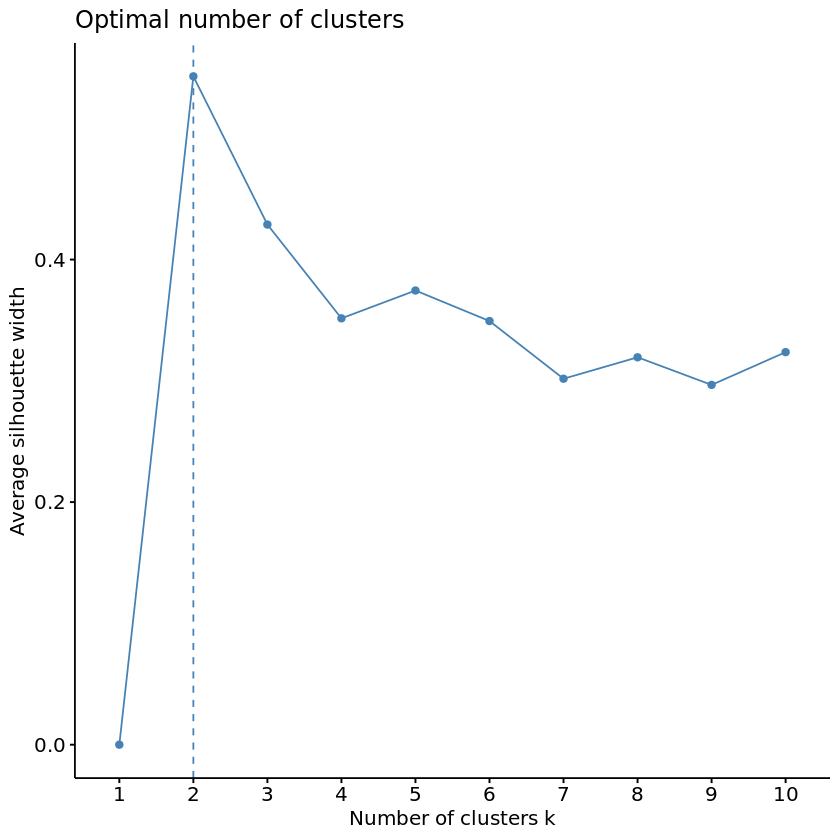

In [8]:
# Run the fviz_nbclust function with the method "silhouette" 
silhouette_method <- fviz_nbclust(k_means_data, kmeans, method ="silhouette")

# View the plot
silhouette_method

#### 3c. The gap statistic method
<p> The Gap Statistic Method will compare the total variation within clusters for different values of <em>k</em> to the null hypothesis, maximizing the "gap." The "null hypothesis" refers to a uniformly distributed <em>simulated reference</em> dataset with no observable clusters, generated by aligning with the principle components of our original dataset. In other words, how much more variance is explained by <em>k</em> clusters in our dataset than in a fake dataset where all majors have equal salary potential? </p>
<p> Since this method also states that num_cluster=3 would give better clustering, I will be taking that value when I group my data. </p>

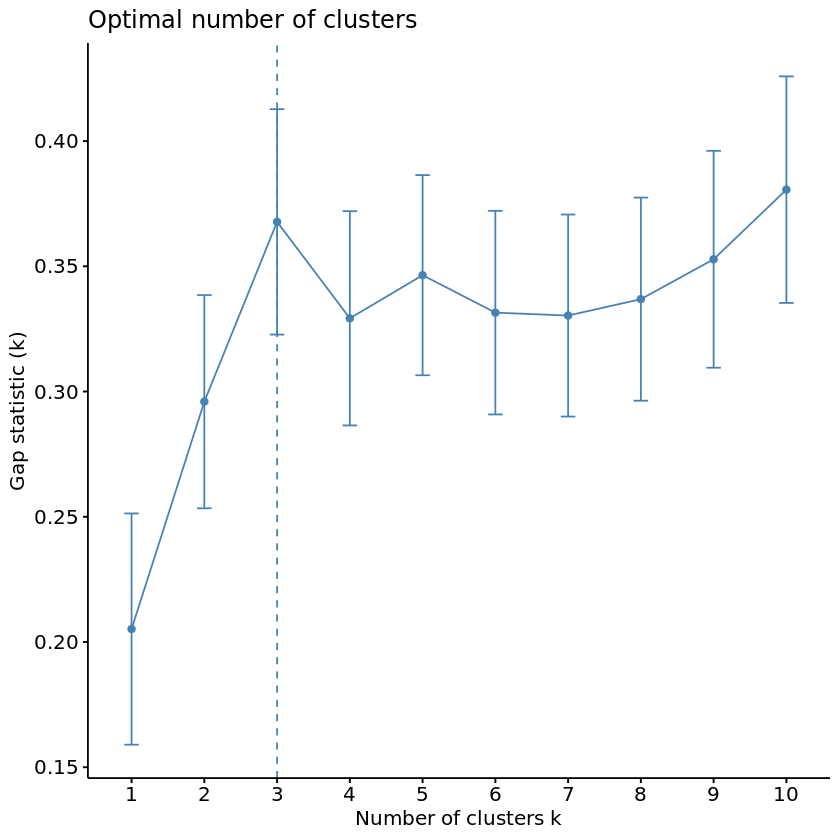

In [10]:
### Method 1 ###
# Use the clusGap function to apply the Gap Statistic Method
gap_stat <- clusGap(k_means_data,FUN =kmeans, nstart=25, K.max = 10, B=50)
# Use the fviz_gap_stat function to vizualize the results
gap_stat_method<- fviz_gap_stat(gap_stat)

# OR
### Method 2 ###
# gap_stat_method <- fviz_nbclust(k_means_data, kmeans, method ="gap_stat")

# View the plot
gap_stat_method

## 6. K-means algorithm

In [12]:
# Set a random seed
set.seed(111)
# .... YOUR CODE FOR TASK 7 ....

# Set k equal to the optimal number of clusters
num_clusters <- 3

# Run the k-means algorithm 
k_means <- kmeans(k_means_data,num_clusters, iter.max=15,nstart=25)

# Label the clusters of degrees_clean
degrees_labeled <- degrees_clean %>%
    mutate(clusters = k_means$cluster)
# k_means$cluster
head(degrees_labeled)

College.Major,Starting.Median.Salary,Mid.Career.Median.Salary,Career.Percent.Growth,Percentile.10,Percentile.25,Percentile.75,Percentile.90,clusters
Accounting,46000,77100,0.676,42200,56100,108000,152000,2
Aerospace Engineering,57700,101000,0.750,64300,82100,127000,161000,3
Agriculture,42600,71900,0.688,36300,52100,96300,150000,2
Anthropology,36800,61500,0.671,33800,45500,89300,138000,1
Architecture,41600,76800,0.846,50600,62200,97000,136000,2
Art History,35800,64900,0.813,28800,42200,87400,125000,1


## 7. Visualizing the clusters
<p>First taking a look at how each cluster compares in Starting vs. Mid Career Median Salaries. We can observe high positive correlation, implying the more the starting salary, the more one generally earns later on in their career. 
</p>

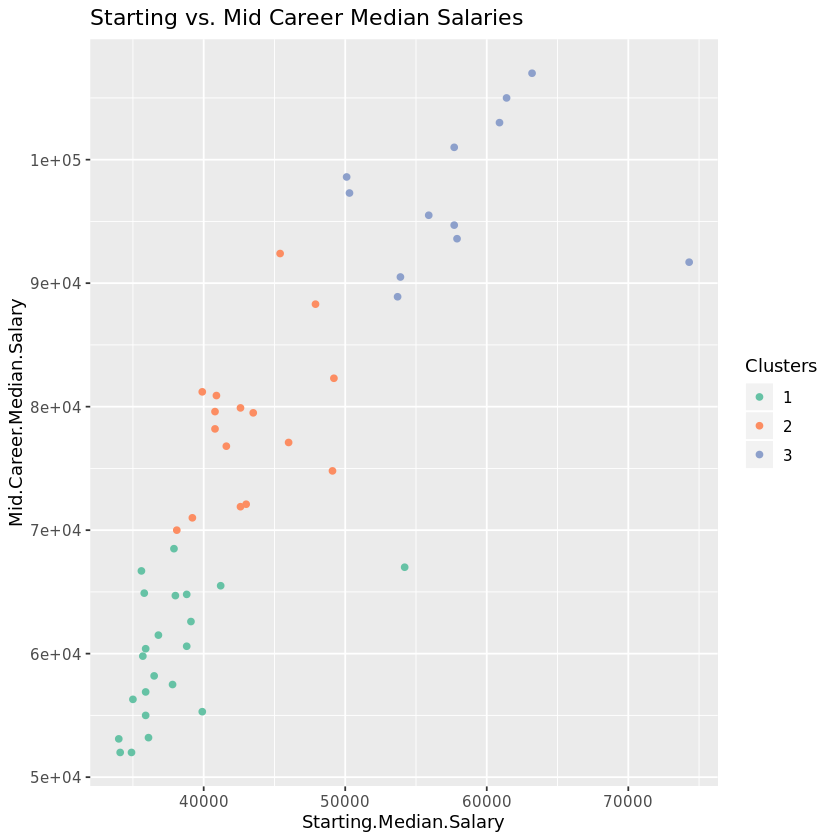

In [29]:
# Graph the clusters by Starting and Mid Career Median Salaries

career_growth <- ggplot(data=degrees_labeled, aes(x=Starting.Median.Salary, y=Mid.Career.Median.Salary)) +
geom_point(aes(colour= factor(clusters))) + scale_colour_brewer('Clusters', palette = 'Set2') + 
ggtitle("Starting vs. Mid Career Median Salaries")

# View the plot
career_growth

## 8. A deeper dive into each clusters

In [16]:
# Use the gather function to reshape degrees and 
# use mutate() to reorder the new percentile column
degrees_perc <- degrees_labeled %>%
    select(College.Major, Percentile.10, Percentile.25, Mid.Career.Median.Salary, Percentile.75, Percentile.90, clusters) %>%
    gather(key="percentile",value="salary", -c(clusters,College.Major)) %>%
    mutate(percentile=factor(percentile, levels=c('Percentile.10', 'Percentile.25', 'Mid.Career.Median.Salary', 'Percentile.75', 'Percentile.90')))
    # .... YOUR CODE FOR TASK 8 ....
degrees_perc

College.Major,clusters,percentile,salary
Accounting,2,Percentile.10,42200
Aerospace Engineering,3,Percentile.10,64300
Agriculture,2,Percentile.10,36300
Anthropology,1,Percentile.10,33800
Architecture,2,Percentile.10,50600
Art History,1,Percentile.10,28800
Biology,1,Percentile.10,36900
Business Management,2,Percentile.10,38800
Chemical Engineering,3,Percentile.10,71900
Chemistry,2,Percentile.10,45300


## 9. The Artistic cluster
<p>These Liberal Arts majors may represent the lowest percentiles with limited growth opportunity, but there is hope for those who make it! Music is our riskiest major with the lowest 10th percentile salary, but Drama wins the highest growth potential in the 90th percentile for this cluster (so don't let go of those Hollywood dreams!). Nursing is the outlier culprit of cluster number 1, with a higher safety net in the lowest percentile to the median. Otherwise, this cluster does represent the majors with limited growth opportunity.</p>
<p>An aside: It's worth noting that most of these majors leading to lower-paying jobs are women-dominated, according to this <a href="https://www.glassdoor.com/research/app/uploads/sites/2/2017/04/FULL-STUDY-PDF-Gender-Pay-Gap2FCollege-Major.pdf">Glassdoor study</a>. According to the research:</p>
<blockquote>
  <p>"The single biggest cause of the gender pay gap is occupation and industry sorting of men and women into jobs that pay differently throughout the economy. In the U.S., occupation and industry sorting explains 54 percent of the overall pay gap—by far the largest factor." </p>
</blockquote>
<p>Does this imply that women are statistically choosing majors with lower pay potential, or do certain jobs pay less because women choose them…? </p>

<p> Well personally, I feel liberal arts is something, as a woman, is intuitive to me. I like coordinating my dresses from when I was young so I can believe that the creative part of my brain works well. Additionally, I know women can give birth, so I think it's just within us to be more emotional and caring, i.e. a natural nurse (or it can be just those dramatic emotional series I love watching making this bias ;P). Lastly, I am currently in a Computers Major and it's very interesting but competitive here, so I sometimes wonder under the stress, wouldn't a more secure job be less worrying and more enjoyable? </p>

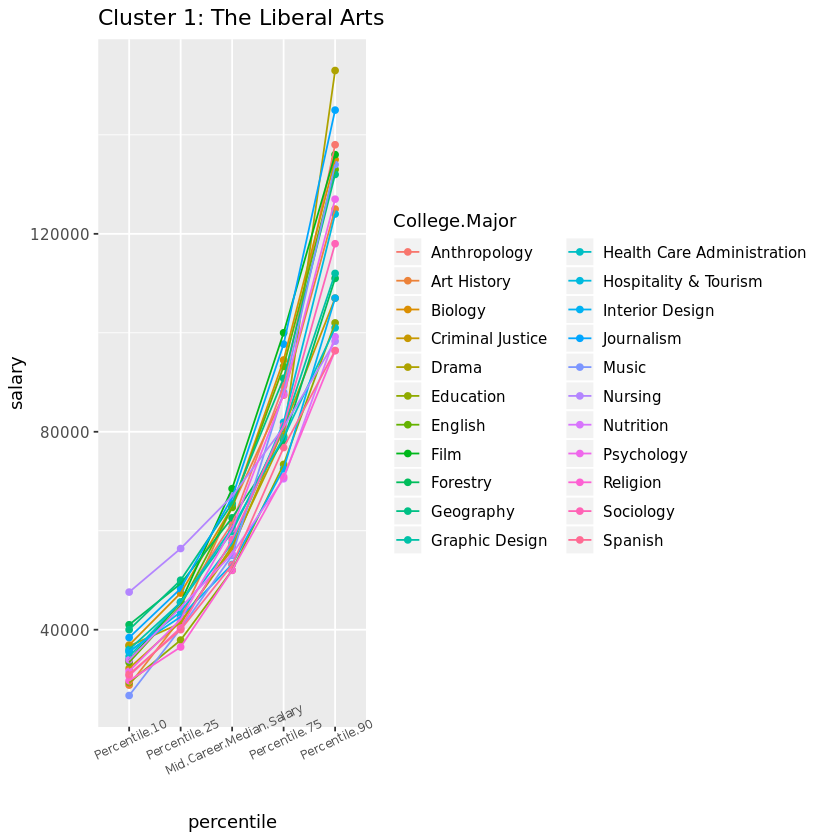

In [ ]:
# Graph the majors of Cluster 1 by percentile
cluster_1 <-  ggplot(filter(degrees_perc, clusters==1), aes(x=percentile, y=salary, group=College.Major, color=College.Major), title="Cluster 1: The Artistics") +
                geom_point() +
                geom_line() +
                theme(axis.text.x = element_text(size=7, angle=25))

# View the plot
cluster_1

## 10. The Financials cluster
<p>On to Cluster 2, right in the middle! Accountants are known for having stable job security, but once you're in the big leagues you may be surprised to find that Marketing or Philosophy can ultimately result in higher salaries. The majors of this cluster are fairly middle of the road in our dataset, starting off not too low and not too high in the lowest percentile. However, this cluster also represents the majors with the greatest differential between the lowest and highest percentiles. So I guess you need the right chance to make the jump to the next percentile...?</p>

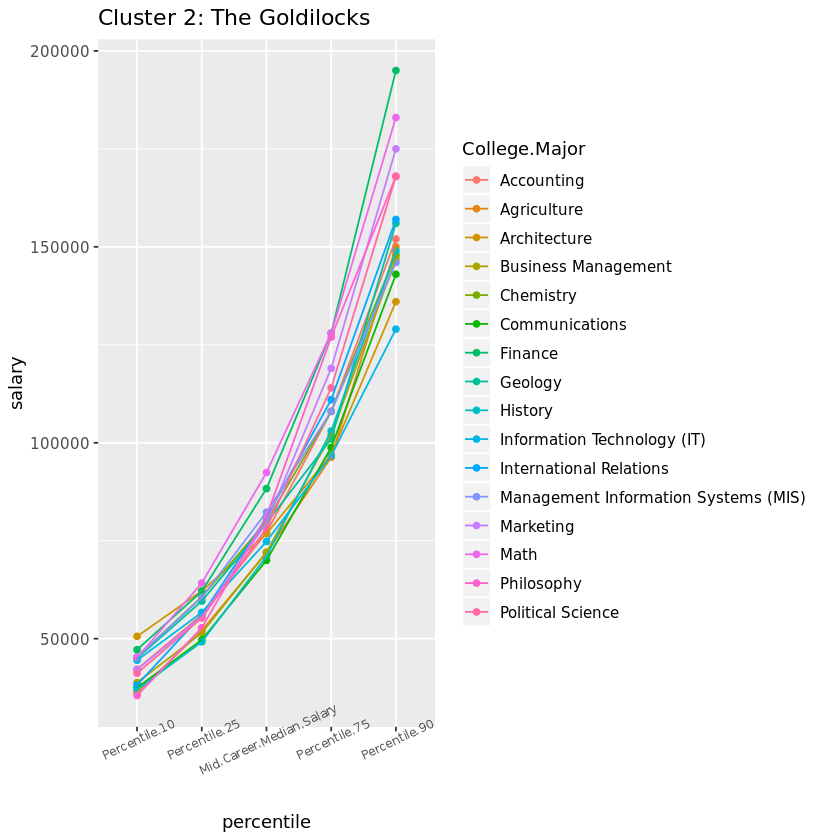

In [20]:
# Graph the majors of Cluster 1 by percentile
cluster_2 <-  ggplot(filter(degrees_perc, clusters==2), aes(x=percentile, y=salary, group=College.Major, color=College.Major), title="Cluster 2: The Financials") +
                geom_point() + ggtitle("Cluster 2: The Financials") +
                geom_line() +
                theme(axis.text.x = element_text(size=7, angle=25))

# View the plot
cluster_2

## 11. The Engineers
<p>Finally, Cluster 3. If you want financial security, these are the majors to choose from. Besides our one previously observed outlier now identifiable as Physician Assistant lagging in the highest percentiles, these heavy hitters and solid engineers represent the highest growth potential in the 90th percentile, as well as the best security in the 10th percentile rankings. </p>

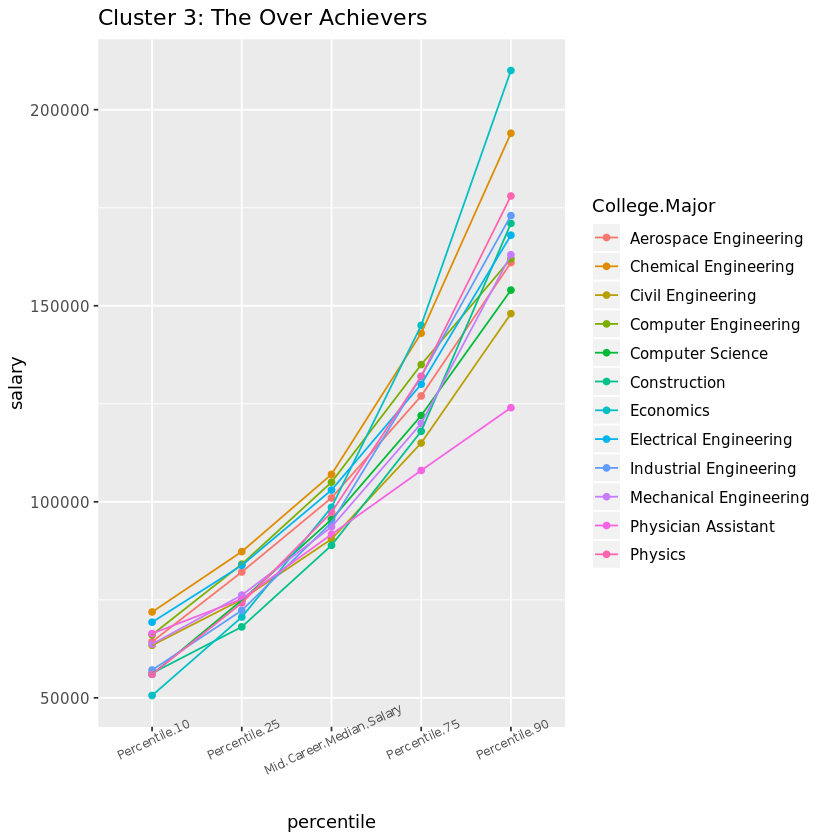

In [22]:
# Graph the majors of Cluster 1 by percentile
cluster_3 <-  ggplot(filter(degrees_perc, clusters==3), aes(x=percentile, y=salary, group=College.Major, color=College.Major), title="Cluster 3: The Engineers") +
                geom_point() + ggtitle("Cluster 3: The Engineers") +
                geom_line() +
                theme(axis.text.x = element_text(size=7, angle=25))

# View the plot
cluster_3

## 12. Every major's wonderful
<p>Thus concludes my journey exploring salary projections by college major via a k-means clustering analysis! Dealing with unsupervized data always requires a bit of creativity, such as the usage of three popular methods to determine the optimal number of clusters. </p>

<p>While it's tempting to focus on starting career salaries when choosing a major, it's important to also consider the growth potential down the road. Keep in mind that one's financial destiny will certainly be influenced by numerous other factors including the school attended, location, passion or talent for the subject, and of course the actual career(s) pursued. </p>

<p>A similar analysis to evaluate these factors may be conducted on the additional data provided by the Wall Street Journal article, comparing salary potential by type and region of college attended. But in the meantime, here's some inspiration from <a href="https://xkcd.com/1052/">xkcd</a> for any students out there still struggling to choose a major.

NOTE: Observe the growth potentials of each career as below. Maths and Philosophy have the largest career growth potential.</p>

In [26]:
# Sort degrees by Career.Percent.Growth
# .... YOUR CODE FOR TASK 12 ....
arrange(degrees_labeled, desc(Career.Percent.Growth))
# Identify the two majors tied for highest career growth potential
highest_career_growth <- c('Math','Philosophy')

College.Major,Starting.Median.Salary,Mid.Career.Median.Salary,Career.Percent.Growth,Percentile.10,Percentile.25,Percentile.75,Percentile.90,clusters
Math,45400,92400,1.035,45200,64200,128000,183000,2
Philosophy,39900,81200,1.035,35500,52800,127000,168000,2
International Relations,40900,80900,0.978,38200,56000,111000,157000,2
Economics,50100,98600,0.968,50600,70600,145000,210000,3
Marketing,40800,79600,0.951,42100,55600,119000,175000,2
Physics,50300,97300,0.934,56000,74200,132000,178000,3
Political Science,40800,78200,0.917,41200,55300,114000,168000,2
Chemistry,42600,79900,0.876,45300,60700,108000,148000,2
Journalism,35600,66700,0.874,38400,48300,97700,145000,1
Architecture,41600,76800,0.846,50600,62200,97000,136000,2
